In [22]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import georasters as gr
import seaborn as sns
from scipy.interpolate import griddata

In [2]:
vlm = pd.read_excel('data.xls')
file = 'Elevation.tif'
elevation = gr.from_file(file)
df = elevation.to_pandas()

In [88]:
gdf = elevation.to_geopandas()

In [89]:
gdf

,row,col,value,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014..."
1,0,2348,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014..."
2,0,2349,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014..."
3,0,2350,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014..."
4,0,2351,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014..."
...,...,...,...,...,...,...
1789656,1757,2516,37.0,54.698750,24.212083,"POLYGON ((54.69875 24.21208, 54.69903 24.21208..."
1789657,1757,2517,36.0,54.699028,24.212083,"POLYGON ((54.69903 24.21208, 54.69931 24.21208..."
1789658,1757,2518,37.0,54.699306,24.212083,"POLYGON ((54.69931 24.21208, 54.69958 24.21208..."
1789659,1757,2519,38.0,54.699584,24.212083,"POLYGON ((54.69958 24.21208, 54.69986 24.21208..."


In [87]:
elevation.shape

(1758, 2521)

In [4]:
df.head()

,row,col,value,x,y
0,0,2347,1.0,54.651806,24.700139
1,0,2348,0.0,54.652084,24.700139
2,0,2349,1.0,54.652361,24.700139
3,0,2350,1.0,54.652639,24.700139
4,0,2351,2.0,54.652917,24.700139


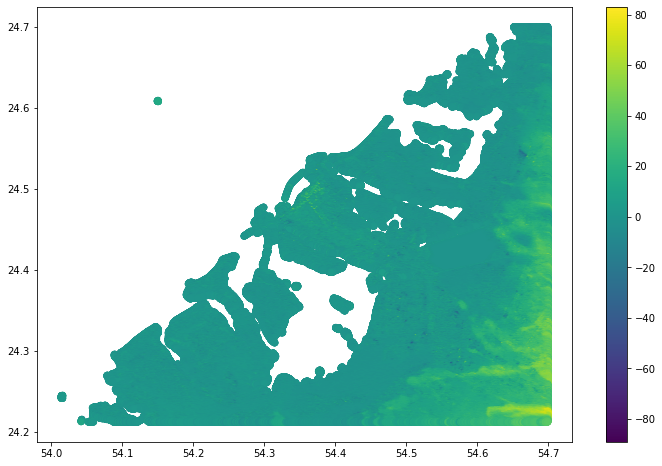

In [17]:
cmap = sns.cubehelix_palette(as_cmap=True)
plt.figure(figsize=(12, 8))
points = plt.scatter(df.x, df.y, c=df.value)
plt.colorbar(points)
plt.show()

In [19]:
vlm_new = vlm.drop(columns=['Station', 'VLM_std'], axis=1)
min_x, max_x = vlm_new.Longitude.min(), vlm_new.Longitude.max()
min_y, max_y = vlm_new.Latitude.min(), vlm_new.Latitude.max()

In [20]:
vlm_points = vlm_new[['Longitude', 'Latitude']].values
vlm_values = vlm_new.VLM.values
elev_coor = df[['x', 'y']].values

In [82]:
vlm_points[:5]

array([[54.684594, 24.796595],
       [54.115618, 24.303783],
       [53.848164, 24.056855],
       [53.141386, 24.147625],
       [52.587928, 24.171598]])

In [83]:
vlm_points.shape

(27, 2)

In [84]:
vlm_values.shape

(27,)

In [86]:
elev_coor[:5]

array([[54.65180585, 24.70013871],
       [54.65208362, 24.70013871],
       [54.6523614 , 24.70013871],
       [54.65263918, 24.70013871],
       [54.65291696, 24.70013871]])

In [30]:
gridz0 = griddata(vlm_points, vlm_values, elev_coor, method='nearest')
gridz1 = griddata(vlm_points, vlm_values, elev_coor, method='linear')
gridz2 = griddata(vlm_points, vlm_values, elev_coor, method='cubic')

In [31]:
interpolation = df[['x', 'y', 'value']]
interpolation.rename(columns={'value': 'Elevation'}, inplace=True)
interpolation.head()

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,x,y,Elevation
0,54.651806,24.700139,1.0
1,54.652084,24.700139,0.0
2,54.652361,24.700139,1.0
3,54.652639,24.700139,1.0
4,54.652917,24.700139,2.0


In [34]:
interpolation['Nearest'] = gridz0
interpolation['Linear'] = gridz1
interpolation['Cubic'] = gridz2
interpolation.head()

<ipython-input-34-d32fba4fcfd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolation['Nearest'] = gridz0


,x,y,Elevation,Nearest,Linear,Cubic
0,54.651806,24.700139,1.0,2.471,1.455849,1.984469
1,54.652084,24.700139,0.0,2.471,1.463968,1.989804
2,54.652361,24.700139,1.0,2.471,1.472088,1.995105
3,54.652639,24.700139,1.0,2.471,1.480207,2.000375
4,54.652917,24.700139,2.0,2.471,1.488327,2.005611


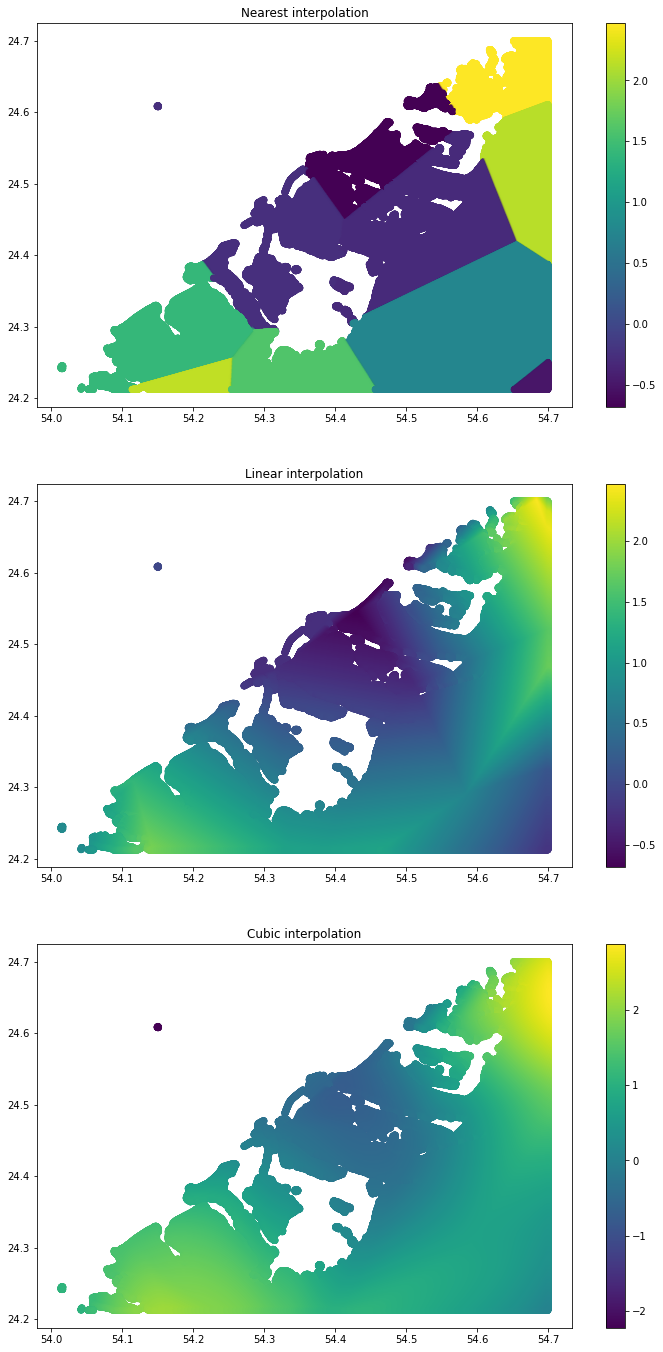

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 24))
# fig.suptitle('Vertically stacked subplots')
points1 = ax1.scatter(interpolation.x, interpolation.y, c=interpolation.Nearest)
ax1.set_title('Nearest interpolation')
fig.colorbar(points1, ax=ax1)
points2 = ax2.scatter(interpolation.x, interpolation.y, c=interpolation.Linear)
ax2.set_title('Linear interpolation')
fig.colorbar(points2, ax=ax2)
points3 = ax3.scatter(interpolation.x, interpolation.y, c=interpolation.Cubic)
ax3.set_title('Cubic interpolation')
fig.colorbar(points3, ax=ax3)
plt.show()

In [45]:
slr = pd.read_excel('data.xls', sheet_name=1, skiprows=15)[['Scenario', 'RSL in 2030 (cm)',
                                                            'RSL in 2050 (cm)', 'RSL in 2080 (cm)', 'RSL in 2100 (cm)']]

In [46]:
slr_new = slr.loc[(slr.Scenario == '0.3 - LOW') |  (slr.Scenario == '2.5 - HIGH')]
slr_new['SL'] = slr_new.sum(axis=1)
slr_new

<ipython-input-46-bb687f515d63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slr_new['SL'] = slr_new.sum(axis=1)


,Scenario,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),SL
1,0.3 - LOW,10,15,21,22,68
17,2.5 - HIGH,55,114,241,357,767


In [50]:
elev_values = df[['value']].values.flatten()
interpolation['AE - Low'] = elev_values - slr_new.iloc[0].SL + gridz0
interpolation['AE - High'] = elev_values - slr_new.iloc[1].SL + gridz0

In [69]:
ae_min = min(interpolation['AE - Low'].min(), interpolation['AE - High'].min())
ae_max = max(interpolation['AE - Low'].max(), interpolation['AE - High'].max())

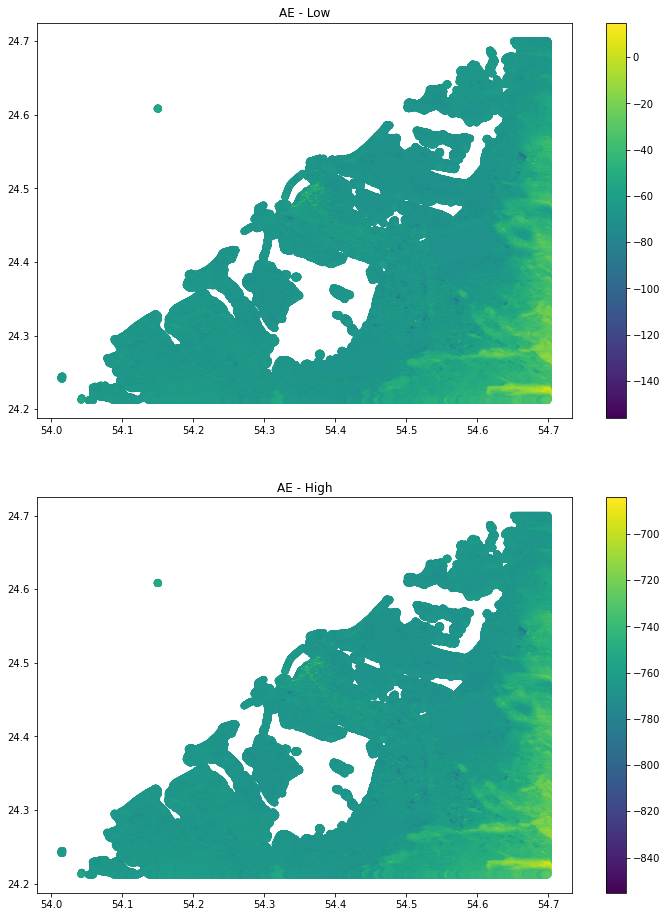

In [81]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 16))
# fig.suptitle('Vertically stacked subplots')
points1 = ax1.scatter(interpolation.x, interpolation.y, c=interpolation['AE - Low'])
ax1.set_title('AE - Low')
# norm_colors1 = ax1.pcolor(interpolation.x, interpolation.y, interpolation['AE - Low'], vmin=ae_min, vmax=ae_max)
fig.colorbar(points1, ax=ax1)
points2 = ax2.scatter(interpolation.x, interpolation.y, c=interpolation['AE - High'])
ax2.set_title('AE - High')
fig.colorbar(points2, ax=ax2)
plt.show()

In [79]:
interpolation.x.shape, interpolation.y.shape, interpolation['AE - Low'].shape

((1789661,), (1789661,), (1789661,))

In [80]:
interpolation.x.reshape(-1, 1).shape

AttributeError: 'Series' object has no attribute 'reshape'

p = m.pcolor(lons, lats, (plticemean2019-plticemean2015) * 100,
             latlon=True, cmap=cmocean.cm.curl,
             vmin=-20, vmax=20)
Clare Eayrs to Everyone (4:19 PM)
https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html might help
Clare Eayrs to Everyone (4:37 PM)
https://geohackweek.github.io/raster/04-workingwithrasters/

https://gis.stackexchange.com/questions/346288/extract-all-pixels-values-from-geotiff-with-python

https://hatarilabs.com/ih-en/extract-point-value-from-a-raster-file-with-python-geopandas-and-rasterio-tutorial